Train  a classifier to identify which particle generated the jets (a task called jet tagging), choosing among the following five possibilities: gluons (g), quarks (q), W bosons (W), Z bosons (Z), and top quarks (t). For this task, you should provide a successful training history, a ROC curve plot with the five classes projected, and a confusion matrix.

---

Trained on paid colab with L4 GPU

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import h5py
import pandas as pd
import glob


In [ ]:
# Get the data
#! git clone https://github.com/pierinim/tutorials.git
#! ls tutorials/Data/JetDataset/

!wget https://zenodo.org/api/records/3602254/files/hls4ml_LHCjet_100p_val.tar.gz/content -O zenodo.tar.gz
!tar -xvzf zenodo.tar.gz
!ls val/

--2024-12-15 09:01:48--  https://zenodo.org/api/records/3602254/files/hls4ml_LHCjet_100p_val.tar.gz/content
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1051808139 (1003M) [application/octet-stream]
Saving to: ‘zenodo.tar.gz’

zenodo.tar.gz       100%[===================>]   1003M  11.9MB/s    in 87s     

2024-12-15 09:03:16 (11.6 MB/s) - ‘zenodo.tar.gz’ saved [1051808139/1051808139]

val/jetImage_7_100p_0_10000.h5
val/jetImage_7_100p_10000_20000.h5
val/jetImage_7_100p_30000_40000.h5
val/jetImage_7_100p_40000_50000.h5
val/jetImage_7_100p_50000_60000.h5
val/jetImage_7_100p_60000_70000.h5
val/jetImage_7_100p_70000_80000.h5
val/jetImage_7_100p_80000_90000.h5
val/jetImage_8_100p_0_10000.h5
val/jetImage_8_100p_10000_20000.h5
val/jetImage_8_100p_20000_30000.h5
val/jetImage_8_100p_30000_40000.h5
val/jetImage_8_100p_40000_50000

In [ ]:
target = np.array([])
features = np.array([])

# if we cannot load all data on Colab, we just take a few of them
#datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5','tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5','tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5','tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5','tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']

for fileIN in glob.glob("val/*100p*h5"):
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,:-6])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, features.shape)

Appending val/jetImage_8_100p_50000_60000.h5
Appending val/jetImage_7_100p_80000_90000.h5
Appending val/jetImage_7_100p_0_10000.h5
Appending val/jetImage_9_100p_70000_80000.h5
Appending val/jetImage_8_100p_60000_70000.h5
Appending val/jetImage_7_100p_60000_70000.h5
Appending val/jetImage_7_100p_50000_60000.h5
Appending val/jetImage_9_100p_40000_50000.h5
Appending val/jetImage_8_100p_70000_80000.h5
Appending val/jetImage_7_100p_70000_80000.h5
Appending val/jetImage_8_100p_30000_40000.h5
Appending val/jetImage_8_100p_0_10000.h5
Appending val/jetImage_8_100p_20000_30000.h5
Appending val/jetImage_8_100p_10000_20000.h5
Appending val/jetImage_9_100p_60000_70000.h5
Appending val/jetImage_9_100p_80000_90000.h5
Appending val/jetImage_7_100p_30000_40000.h5
Appending val/jetImage_9_100p_30000_40000.h5
Appending val/jetImage_9_100p_0_10000.h5
Appending val/jetImage_8_100p_40000_50000.h5
Appending val/jetImage_9_100p_10000_20000.h5
Appending val/jetImage_7_100p_10000_20000.h5
Appending val/jetImage

The ground truth is one-hot encoded in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] format, so that
- [1, 0, 0, 0, 0] for gluons
- [0, 1, 0, 0, 0] for quarks
- [0, 0, 1, 0, 0] for Ws
- [0, 0, 0, 1, 0] for Zs
- [0, 0, 0, 0, 1] for tops

The information is contained at the end of the feature vector

In [ ]:
# RE-RUN this before re-training model
#
# Split data into training (60%), test (20%), and validation (20%)
X_train, X_tmp, y_train, y_tmp = train_test_split(features, target, test_size=0.4, random_state=31)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=31)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)
del X_tmp, y_tmp

(144000, 53) (48000, 53) (48000, 53) (144000, 5) (48000, 5) (48000, 5)


In [ ]:
drop_rate = 0.25

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))

# 80 * 75% = 60 ~ 53
model.add(Dense(80, activation='relu'))
model.add(Dropout(drop_rate))

model.add(Dense(60, activation='relu'))
model.add(Dropout(drop_rate))

model.add(Dense(40, activation='relu'))
model.add(Dropout(drop_rate))

model.add(Dense(20, activation='relu'))
model.add(Dropout(drop_rate))

model.add(Dense(10, activation='relu'))
model.add(Dropout(drop_rate))

model.add(Dense(5, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_79 (Dense)                     │ (None, 80)                  │           4,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 60)                  │           4,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 40)                  │           2,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 5)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,735 (49.75 KB)

 Trainable params: 12,735 (49.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10, monitor='val_loss')

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128, callbacks=[reduce_lr])

Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.2050 - loss: 2.9414 - val_accuracy: 0.3545 - val_loss: 1.4854 - learning_rate: 0.0010
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3046 - loss: 1.5032 - val_accuracy: 0.4363 - val_loss: 1.3490 - learning_rate: 0.0010
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4152 - loss: 1.3435 - val_accuracy: 0.5904 - val_loss: 1.1023 - learning_rate: 0.0010
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5389 - loss: 1.1641 - val_accuracy: 0.6121 - val_loss: 1.0260 - learning_rate: 0.0010
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5868 - loss: 1.0955 - val_accuracy: 0.6064 - val_loss: 1.0111 - learning_rate: 0.0010
Epoch 6/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6096 - loss: 1.0520 - val_accuracy: 0.6128 - val_loss: 0.9835 - learning_rate: 0.0010
Epoch 7/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6256 - l

In [ ]:
# Plot training history (accuracy and loss)
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()

    plt.show()

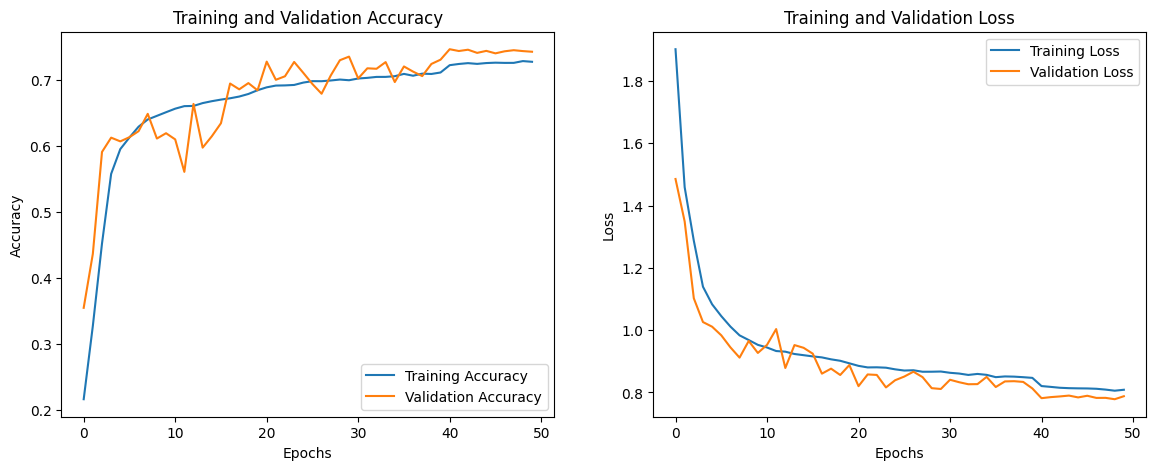

In [ ]:
plot_training_history(history)

In [ ]:
def plot_roc(model, X_test, y_test):
    labels = ['gluon', 'quark', 'W', 'Z', 'top']

    predict_val = model.predict(X_test)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure()
    for i, label in enumerate(labels):
            df[label] = y_test[:,i]
            df[label + '_pred'] = predict_val[:,i]

            fpr[label], tpr[label], _ = roc_curve(df[label],df[label+'_pred'])
            roc_auc[label] = auc(fpr[label], tpr[label])
            plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = { roc_auc[label]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


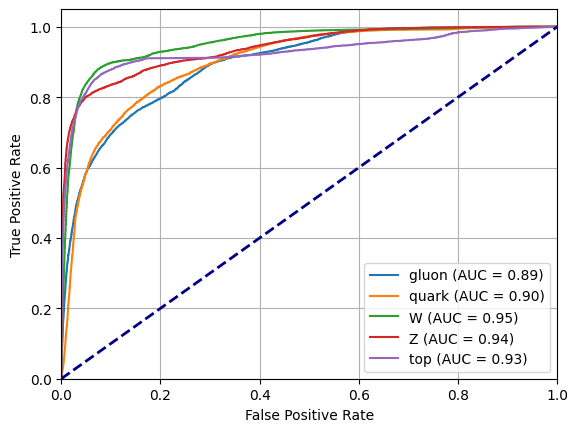

In [ ]:
plot_roc(model, X_test, y_test)

In [ ]:
def plot_conf(model, X_test, y_test):
    labels = ['gluon', 'quark', 'W', 'Z', 'top']

    # Confusion Matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


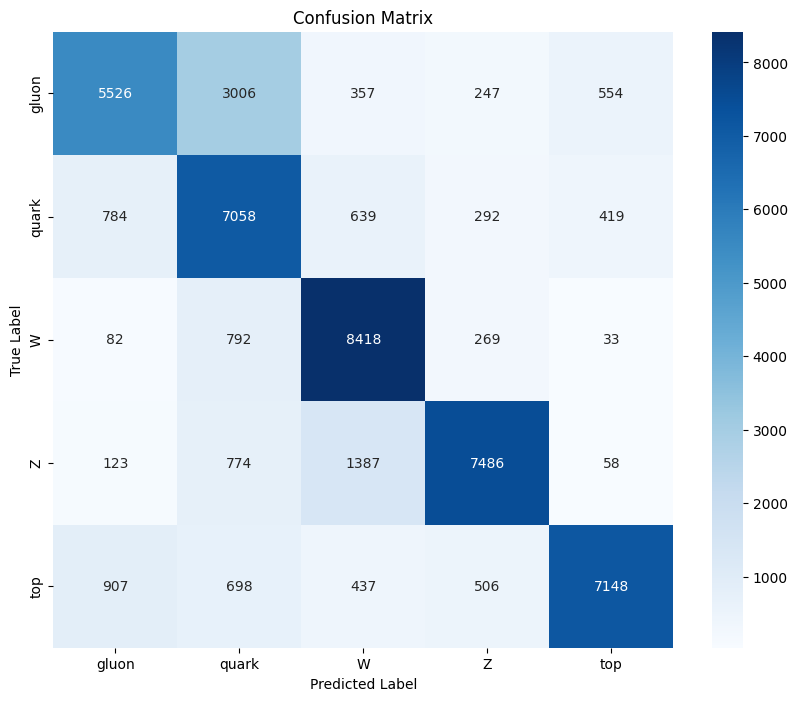

In [ ]:
plot_conf(model, X_test, y_test)